In [4]:
import pandas as pd

df = pd.read_excel("/Users/moad/Desktop/NLP/data/customer_responses_2025.xlsx")
pd.set_option('display.max_colwidth', None)

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from nltk.sentiment import SentimentIntensityAnalyzer 
from tqdm import tqdm
import seaborn as sns

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

## Preprocessing the data

#### Required libraries

In [6]:
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')

#### Required functions

In [7]:
def cleaning_text(col):
    '''
    Takes in input a df[column], it deletes special caracters, numbers and deals with contractions like don't => do not
    '''
    pattern = r'[^\w\s]'
    number_pattern = r'\d+'
    col = col.astype(str)
    col = col.apply(lambda x: re.sub(pattern, '', x))
    col = col.apply(lambda x: re.sub(number_pattern, '', x))
    col = col.apply(lambda x: contractions.fix(x))
    col = col.apply(lambda x: x.lower())
    return col

def lemming(text):
    '''
    Takes in input a text cell, it deletes stopwords, tokenizes text and does lemming
    '''
    lemmatizer = WordNetLemmatizer()
    stop_w = stopwords.words('english')
    stop_w.extend(['edinburgh', 'airport', 'Edinburgh', 'Airport'])
    
    tokens = word_tokenize(text)
    filtered_words = [word for word in tokens if word not in stop_w]
    lemm_tokens = [lemmatizer.lemmatize(token) for token in filtered_words]
    lemm_text = ' '.join(lemm_tokens)
    return lemm_text

def token(text):
    '''
    Takes in input a text cell, it will tokenize it
    '''
    tokens = word_tokenize(text)
    return tokens
    

#### Renaming columns and mapping

In [8]:
columns = ['How likely are you to recommend Edinburgh Airport to a friend or colleague?',
           'Overall, were you satisfied with your most recent experience at Edinburgh Airport?',
           'Are there any premium services that you would like to see introduced at Edinburgh?',
           'Do you have any other feedback or suggestions?']

column_mapping = {columns[0] : 'Rates',
                  columns[1] : 'Satisfaction',
                  columns[2] : 'Services_suggestions',
                  columns[3] : 'Feedbacks'} 

satisfaction_mapping = {'Yes' : 1, 'No':0}

In [9]:
df_clean = df[columns].copy()
df_clean.rename(columns = column_mapping, inplace = True)
df_clean['Satisfaction'] = df_clean['Satisfaction'].map(satisfaction_mapping)

df_clean['Feedbacks'] = df_clean['Feedbacks'].fillna("No")
df_clean['Feedbacks_clean'] = cleaning_text(df_clean['Feedbacks'])
df_clean['Feedbacks_lem'] = df_clean['Feedbacks_clean'].apply(lemming)
df_clean['Feedbacks_tokens'] = df_clean['Feedbacks_lem'].apply(token)

df_clean['Services_suggestions'] = df_clean['Services_suggestions'].fillna("No")
df_clean['Suggestions_clean'] = cleaning_text(df_clean['Services_suggestions'])
df_clean['Suggestions_lem'] = df_clean['Suggestions_clean'].apply(lemming)
df_clean['Suggestions_tokens'] = df_clean['Suggestions_lem'].apply(token)

columns_keep = ['Rates','Satisfaction',
                'Feedbacks_clean','Feedbacks_lem','Feedbacks_tokens',
                'Suggestions_clean','Suggestions_lem','Suggestions_tokens']

df_clean = df_clean[columns_keep]
df_clean.head()

,Rates,Satisfaction,Feedbacks_clean,Feedbacks_lem,Feedbacks_tokens,Suggestions_clean,Suggestions_lem,Suggestions_tokens
0,9.0,1.0,no,,[],no,,[]
1,10.0,1.0,no,,[],no,,[]
2,5.0,0.0,sort out the airport own parking so it works when you prepay,sort parking work prepay,"[sort, parking, work, prepay]",just get the basics right first and keep them right the auto passport readers now work very quickly this was previously a problem and still is at other airports,get basic right first keep right auto passport reader work quickly previously problem still airport,"[get, basic, right, first, keep, right, auto, passport, reader, work, quickly, previously, problem, still, airport]"
3,9.0,1.0,no,,[],no,,[]
4,10.0,1.0,no,,[],no,,[]


#### Defining our DataFrames

In [10]:
mask_feedback = df_clean['Feedbacks_lem'].apply(lambda x: len(x) > 5)
mask_suggestion = df_clean['Suggestions_lem'].apply(lambda x: len(x) > 15)

columns_feedback = ['Rates','Satisfaction','Feedbacks_clean','Feedbacks_lem','Feedbacks_tokens']
columns_suggestion = ['Rates','Satisfaction','Suggestions_clean','Suggestions_lem','Suggestions_tokens']

df_feedback = df_clean[mask_feedback]
df_suggestion = df_clean[mask_suggestion]

df_feedback = df_feedback[columns_feedback]
df_suggestion = df_suggestion[columns_suggestion]

display(df_feedback.head(5))
display(df_suggestion.head(5))

,Rates,Satisfaction,Feedbacks_clean,Feedbacks_lem,Feedbacks_tokens
2,5.0,0.0,sort out the airport own parking so it works when you prepay,sort parking work prepay,"[sort, parking, work, prepay]"
9,10.0,1.0,was a first time thru edinburgh airport and was excellent all around service,first time thru excellent around service,"[first, time, thru, excellent, around, service]"
15,5.0,1.0,the british airways check in staff were very kind and helpful,british airway check staff kind helpful,"[british, airway, check, staff, kind, helpful]"
16,9.0,1.0,there should more easy accesible internet,easy accesible internet,"[easy, accesible, internet]"
17,10.0,1.0,gate advisory not less than an hour from departure,gate advisory less hour departure,"[gate, advisory, less, hour, departure]"


,Rates,Satisfaction,Suggestions_clean,Suggestions_lem,Suggestions_tokens
2,5.0,0.0,just get the basics right first and keep them right the auto passport readers now work very quickly this was previously a problem and still is at other airports,get basic right first keep right auto passport reader work quickly previously problem still airport,"[get, basic, right, first, keep, right, auto, passport, reader, work, quickly, previously, problem, still, airport]"
6,10.0,1.0,i prepare for make more sitting areas because i saw many people are standing before waiting for the check in,prepare make sitting area saw many people standing waiting check,"[prepare, make, sitting, area, saw, many, people, standing, waiting, check]"
17,10.0,1.0,tour guide for those who have to hrs or staying over night,tour guide hr staying night,"[tour, guide, hr, staying, night]"
23,8.0,1.0,sleeping pods reclining chairs,sleeping pod reclining chair,"[sleeping, pod, reclining, chair]"
33,6.0,0.0,i do not agree with premium services decent services should be available to all,agree premium service decent service available,"[agree, premium, service, decent, service, available]"


## Sentiment Analysis : Vader

#### Required libraries

In [11]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy

#### Required functions

In [12]:
def sentiment_score(col):
    nlp = spacy.load('en_core_web_sm')
    analyzer = SentimentIntensityAnalyzer()
    col_score = col.apply(lambda x: analyzer.polarity_scores(x))
    col_score_df = pd.DataFrame(col_score.tolist(), columns=['neg', 'neu', 'pos','compound'])
    return col_score_df

def scoring_vader(df,text):
    scores = sentiment_score(df[text])
    scores = scores.merge(df[['Satisfaction']].reset_index(drop=True), how='left', left_index=True, right_index=True)
    scores = scores.merge(df[['Rates']].reset_index(drop=True), how='left', left_index=True, right_index=True)
    return(scores)

def plot_sentiment(target, df, title = None, roberta = False):
    '''
    Target is 'Rates' or 'Satisfaction'
    '''
    if roberta == True:
        column = ['roberta_pos','roberta_neu','roberta_neg']
    else:    
        column = ['pos','neu','neg']
    
    labels = ['Positive','Neutral','Negative']
    target_column = target

    fig, axs = plt.subplots(1,3,figsize = (13,3))
    fig.suptitle(f"Sentiment Analysis - Target variable: '{target}' (Dataset: {title})", fontsize = 10, y=1.05) 
    plt.subplots_adjust(hspace = 0.9)

    for i in range(3):
        sns.barplot(data=df, x=target, y=column[i], ax = axs[i], errorbar = None)
        axs[i].set_title(labels[i], fontsize = 8)

    for ax in axs:
        ax.margins(y=0.1)
        ax.margins(x=0.03)
        ax.set_ylabel('')
        ax.set_xlabel(ax.get_xlabel(),fontsize=8)
        ax.tick_params(axis='both', labelsize = 8)

        total = 0
        for j in ax.patches:
                total = total + j.get_height()
        
        for p in ax.patches:
            bar_height = p.get_height()
            percentage = 100 * bar_height / total
            ax.annotate(f'{percentage:.1f}%', 
                    (p.get_x() + p.get_width() / 2., bar_height),
                    ha='center', va='bottom',
                    fontsize=7.5, color='black')

def heatmap(df,title):
    correlation_matrix = df.corr(method = "spearman")
    sns.set_theme(style="white")
    plt.figure(figsize = (5,4))
    heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Spearman Correlation"})
    heatmap.set_title(f"{title}", fontsize = 10)
    heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize = 10)
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, fontsize = 9)
    plt.show()

#### Defining our DataFrames

In [13]:
vader_feedback = scoring_vader(df_feedback, 'Feedbacks_lem')
vader_suggestion = scoring_vader(df_suggestion, 'Suggestions_lem')

display(vader_feedback.head(3))
display(vader_suggestion.head(3))

,neg,neu,pos,compound,Satisfaction,Rates
0,0.0,1.000,0.000,0.0000,0.0,5.0
1,0.0,0.575,0.425,0.5719,1.0,10.0
2,0.0,0.392,0.608,0.7351,1.0,5.0


,neg,neu,pos,compound,Satisfaction,Rates
0,0.162,0.838,0.0,-0.4019,0.0,5.0
1,0.000,1.000,0.0,0.0000,1.0,10.0
2,0.000,1.000,0.0,0.0000,1.0,10.0


#### Plotting our analysis

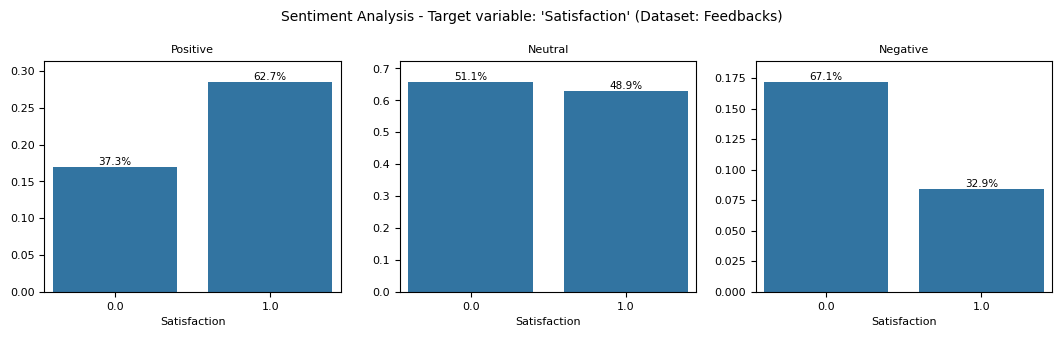

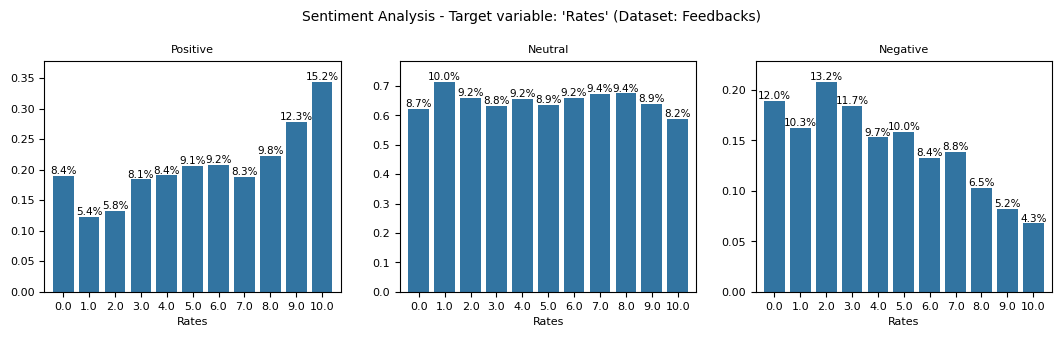

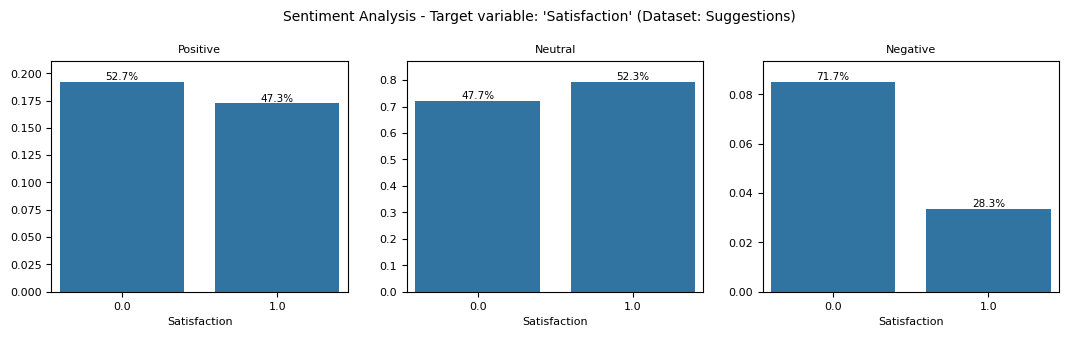

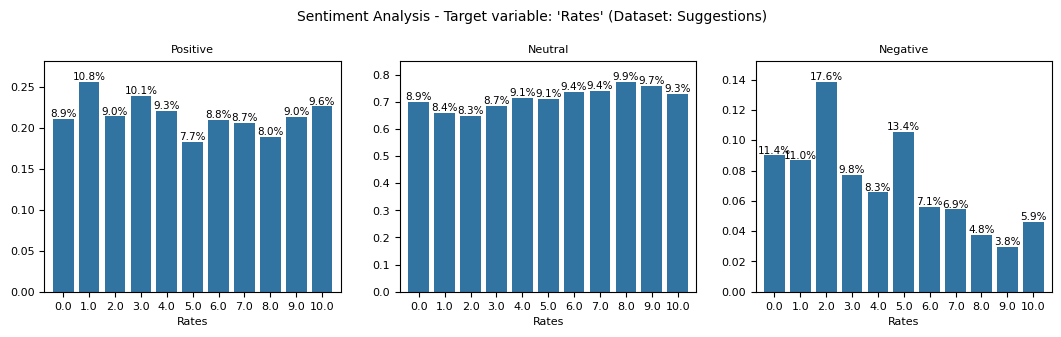

In [14]:
plot_sentiment('Satisfaction', vader_feedback, 'Feedbacks')
plot_sentiment('Rates', vader_feedback, 'Feedbacks')
plot_sentiment('Satisfaction', vader_suggestion, 'Suggestions')
plot_sentiment('Rates', vader_suggestion, 'Suggestions')

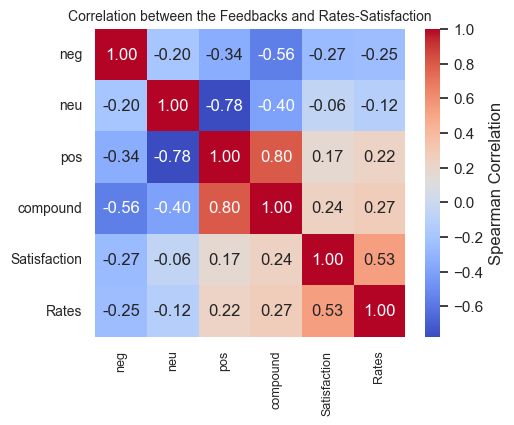

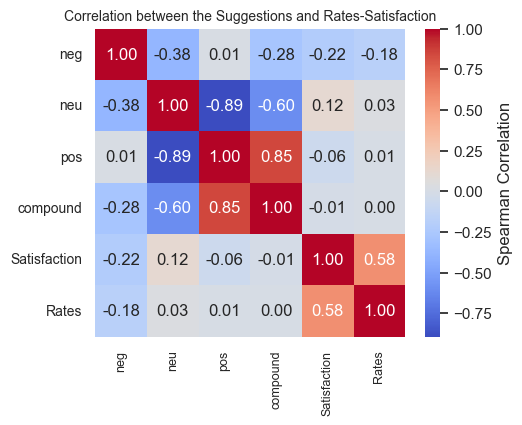

In [15]:
heatmap(vader_feedback,"Correlation between the Feedbacks and Rates-Satisfaction")
heatmap(vader_suggestion,"Correlation between the Suggestions and Rates-Satisfaction")

## Sentiment Analysis : RoBERTa

#### Required libraries

In [16]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm import tqdm
#import os
#os.environ['TOKENIZERS_PARALLELISM'] = 'false'

#### Required functions

In [17]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenize = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

def polarity_scores_robert(text):
    encoded_text = tokenize(text, return_tensors ='pt') 
    output = model(**encoded_text) 
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg': round(scores[0].item(), 8),
    'roberta_neu': round(scores[1].item(), 8),
    'roberta_pos': round(scores[2].item(), 8)}
    return scores_dict

def scoring_roberta(df,column):   
    res = {}
    for i, row in tqdm(df.iterrows(), total = len(df)):
        try:
            text = row[column]
            id = row.name
            roberta_result = polarity_scores_robert(text)
            both = {**roberta_result}
            res[id] = both
        except RuntimeError:
            print(f'Broke for id {id}') #In case tokens over the limit of the model
    '''
    scores = pd.DataFrame(res).T.reset_index(drop=True).merge(df[['Satisfaction']].reset_index(drop=True), 
                 how='left', left_index=True, right_index=True).merge(df[['Rates']].reset_index(drop=True),
                 how='left', left_index=True, right_index=True)
    '''
    scores = (pd.DataFrame(res).T.reset_index(drop=True).merge(df.reset_index(drop=True), how='left', left_index=True, right_index=True))

    return scores

#### Defining our DataFrames

In [18]:
roberta_feedback = scoring_roberta(df_feedback, 'Feedbacks_lem')
roberta_suggestion = scoring_roberta(df_suggestion, 'Suggestions_lem')

100%|█████████████████████████████████████████| 881/881 [00:44<00:00, 19.88it/s]


#### Plotting our analysis

In [19]:
roberta_feedback.head()

,roberta_neg,roberta_neu,roberta_pos,Rates,Satisfaction,Feedbacks_clean,Feedbacks_lem,Feedbacks_tokens
0,0.163168,0.786150,0.050682,5.0,0.0,sort out the airport own parking so it works when you prepay,sort parking work prepay,"[sort, parking, work, prepay]"
1,0.008323,0.143227,0.848450,10.0,1.0,was a first time thru edinburgh airport and was excellent all around service,first time thru excellent around service,"[first, time, thru, excellent, around, service]"
2,0.005589,0.209659,0.784752,5.0,1.0,the british airways check in staff were very kind and helpful,british airway check staff kind helpful,"[british, airway, check, staff, kind, helpful]"
3,0.046155,0.432210,0.521635,9.0,1.0,there should more easy accesible internet,easy accesible internet,"[easy, accesible, internet]"
4,0.051070,0.904834,0.044096,10.0,1.0,gate advisory not less than an hour from departure,gate advisory less hour departure,"[gate, advisory, less, hour, departure]"


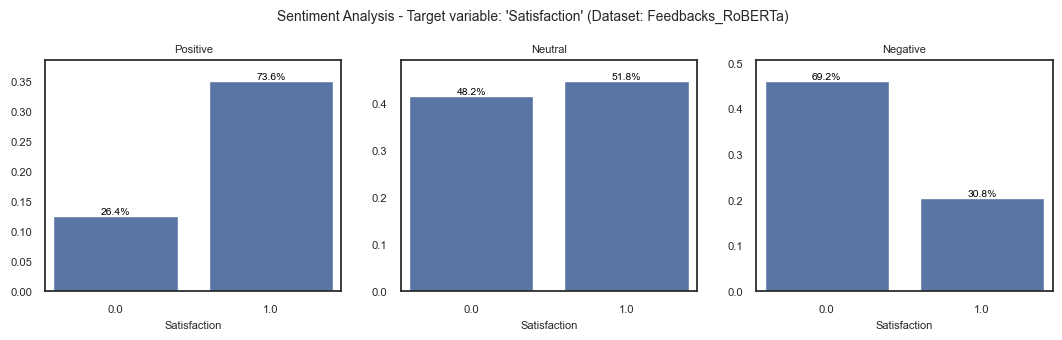

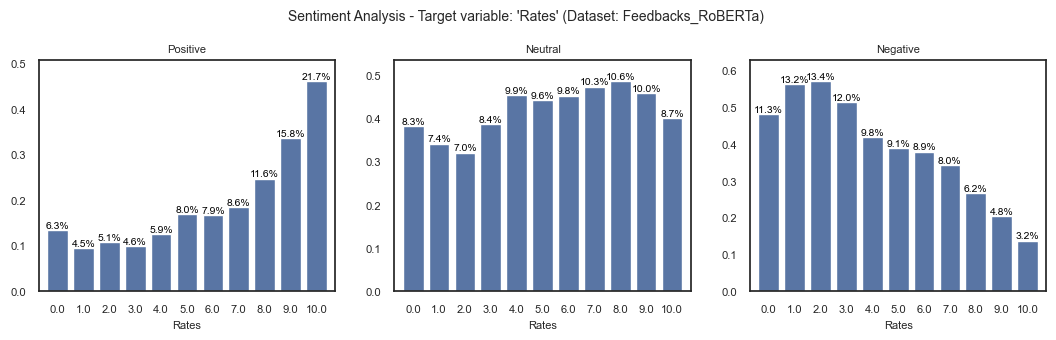

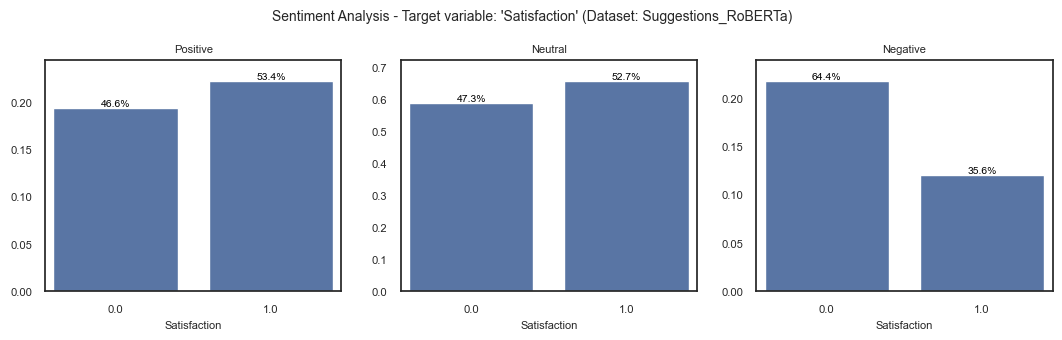

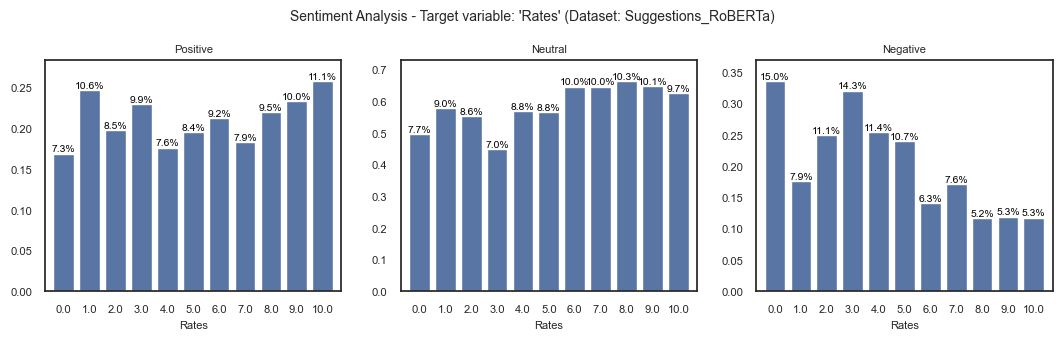

In [20]:
plot_sentiment('Satisfaction', roberta_feedback, 'Feedbacks_RoBERTa', True)
plot_sentiment('Rates', roberta_feedback, 'Feedbacks_RoBERTa', True)
plot_sentiment('Satisfaction', roberta_suggestion, 'Suggestions_RoBERTa', True)
plot_sentiment('Rates', roberta_suggestion, 'Suggestions_RoBERTa', True)

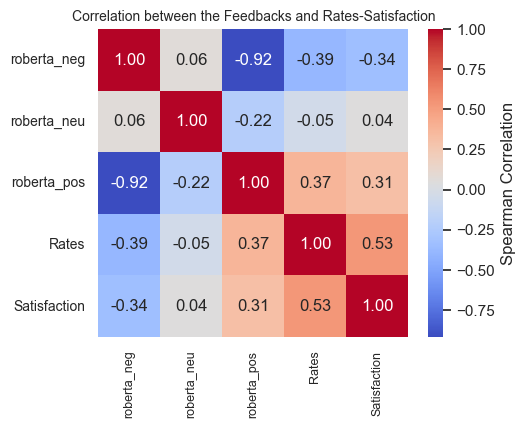

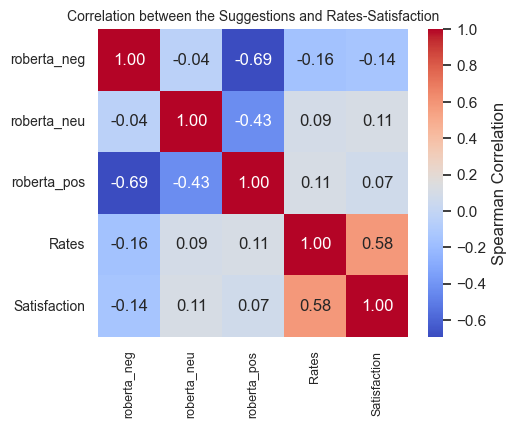

In [21]:
column_heatmap = ['roberta_neg','roberta_neu','roberta_pos','Rates','Satisfaction']
heatmap(roberta_feedback[column_heatmap],"Correlation between the Feedbacks and Rates-Satisfaction")
heatmap(roberta_suggestion[column_heatmap],"Correlation between the Suggestions and Rates-Satisfaction")

## Distribution of satisfaction in our DataFrames

#### Required functions

In [20]:
def distribution(df,target,title=None):
    df_no_na = df.dropna(subset=[target]).copy()
    
    total = len(df_no_na)
    
    if target == 'Rates':
        plt.figure(figsize=(9, 5))
        n_color = df_no_na[target].nunique()
        ax = sns.countplot(x=target, data=df_no_na, hue = target,palette = sns.color_palette("hls", n_color), legend = False)
    else:
        plt.figure(figsize=(4, 4))
        ax = sns.countplot(x=target, data=df_no_na)

    plt.title(f"Distribution of {target} in {title}", fontsize=9)
    for p in ax.patches:
        bar_height = p.get_height()
        percentage = 100 * bar_height / total
        ax.annotate(f'{percentage:.1f}%', 
                    (p.get_x() + p.get_width() / 2., bar_height),
                    ha='center', va='bottom',
                    fontsize=9, color='black')

    

#### Plotting Distributions

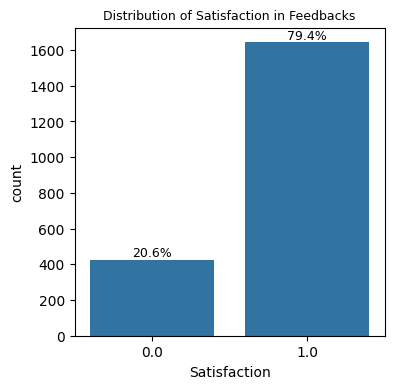

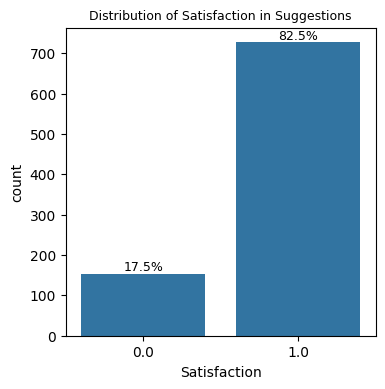

In [21]:
distribution(df_feedback,'Satisfaction','Feedbacks') 
distribution(df_suggestion,'Satisfaction','Suggestions')

## Prediction of satisfaction

#### Required libraries

In [22]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.under_sampling import RandomUnderSampler  
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier  
from scipy.sparse import hstack
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'False'

TF_IDF = TfidfVectorizer()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


#### Required functions

In [23]:
def metrics(xgb,x,y):
        
    y_pred = xgb.predict(x)
    y_prob = xgb.predict_proba(x)[:, 1]

    acc = accuracy_score(y,y_pred)
    auc = roc_auc_score(y,y_prob)

    fpr1, tpr1, thresholds = roc_curve(y, y_prob)
    
    return(fpr1, tpr1, acc, auc)

def plot_curve(xgb,df,target,column,sampler=None):
    
    X = TF_IDF.fit_transform(df[column])
    X = pd.DataFrame(X.toarray())
    
    Y = df[target]

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
  
    if sampler is not None:
        x_train, y_train = sampler.fit_resample(x_train, y_train)
        xgb.fit(x_train, y_train)
    else:
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
        xgb.fit(x_train, y_train, sample_weight=sample_weights)

    fpr1, tpr1, acc_train, auc_train = metrics(xgb, x_train, y_train)
    fpr2, tpr2, acc_test, auc_test = metrics(xgb, x_test, y_test)

    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    if sampler is not None:
        fig.suptitle(f"Prediction of 'Satisfaction' by {sampler}", fontsize=10)
    else:
        fig.suptitle(f"Prediction of 'Satisfaction' by Sampling Weights", fontsize=10)

    # ROC curve for the train set
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].plot(fpr1, tpr1, label=f'AUC = {auc_train:.2f}')
    axes[0].set_title(f'ROC Curve - Train Set (Acc={acc_train:.2f})', fontsize = 8)
    axes[0].set_xlabel('FPR')
    axes[0].set_ylabel('TPR')
    axes[0].legend()

    # ROC curve for the test set
    axes[1].plot([0, 1], [0, 1], 'k--')
    axes[1].plot(fpr2, tpr2, label=f'AUC = {auc_test:.2f}', color='orange')
    axes[1].set_title(f'ROC Curve - Test Set (Acc={acc_test:.2f})', fontsize = 8)
    axes[1].set_xlabel('FPR')
    axes[1].set_ylabel('TPR')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

#### Required DataFrames : deletes nan in the target

In [24]:
df_feedback_no_na = df_feedback.dropna(subset = ['Satisfaction']).copy()
df_suggestion_no_na = df_suggestion.dropna(subset = ['Satisfaction']).copy()

#### Defining our model and samplers

In [25]:
xgb_feedback = XGBClassifier(n_estimators=400,learning_rate=0.01,max_depth=2, random_state=24)
sampler = [RandomUnderSampler(),RandomOverSampler()]

#### Plotting our results based on feedbacks

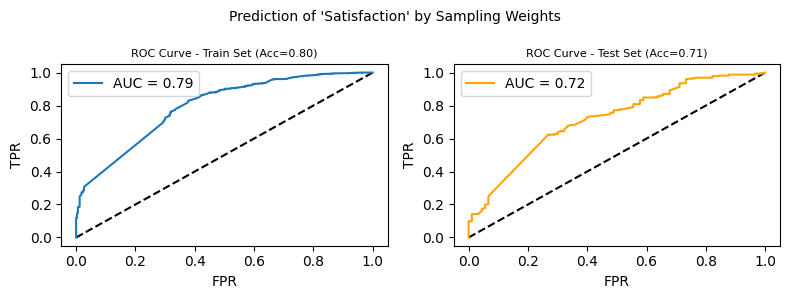

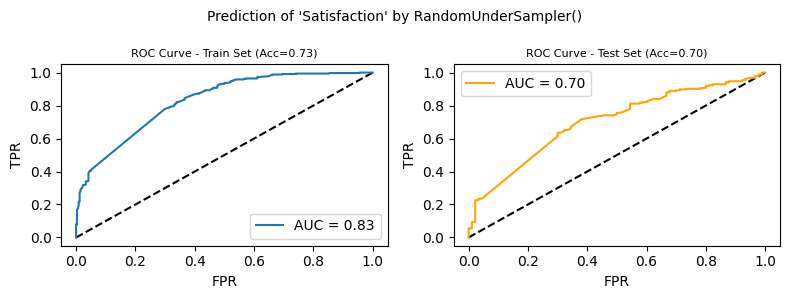

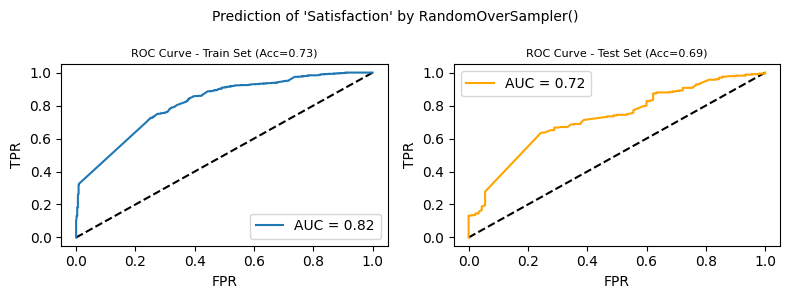

In [26]:
plot_curve(xgb_feedback,df_feedback_no_na,'Satisfaction','Feedbacks_lem')
plot_curve(xgb_feedback,df_feedback_no_na,'Satisfaction','Feedbacks_lem', sampler[0])
plot_curve(xgb_feedback,df_feedback_no_na,'Satisfaction','Feedbacks_lem', sampler[1])

#### Plotting our results based on suggestions

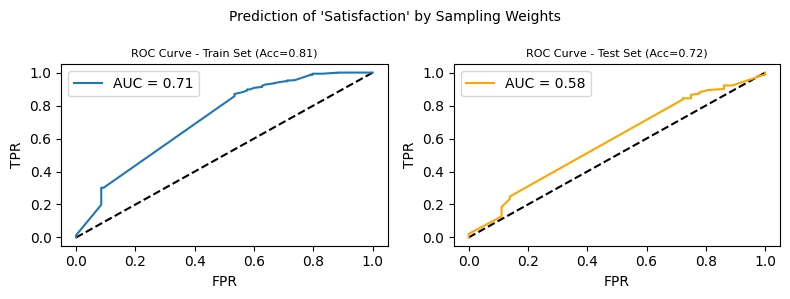

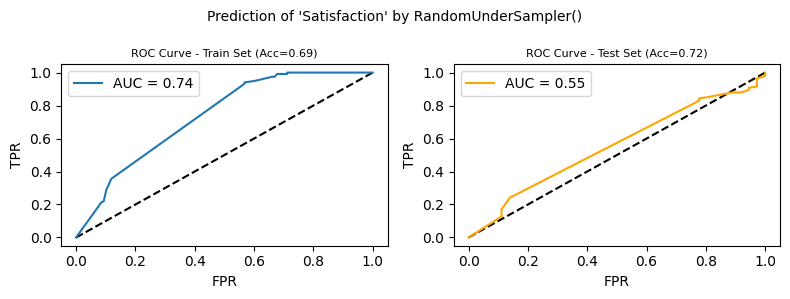

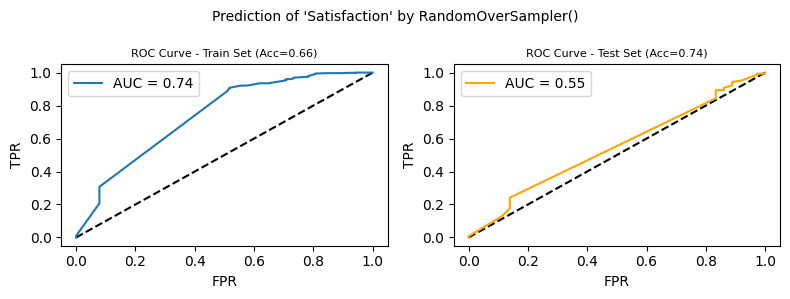

In [27]:
xgb_suggestion = XGBClassifier(n_estimators=1200,learning_rate=0.001,max_depth=2, random_state=24)

plot_curve(xgb_suggestion,df_suggestion_no_na,'Satisfaction','Suggestions_lem')
plot_curve(xgb_suggestion,df_suggestion_no_na,'Satisfaction','Suggestions_lem', sampler[0])
plot_curve(xgb_suggestion,df_suggestion_no_na,'Satisfaction','Suggestions_lem', sampler[1])

## Distribution of rates in our DataDrames

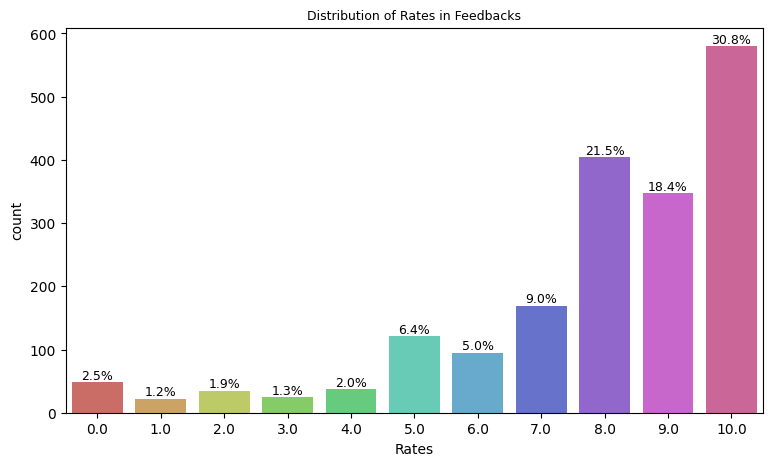

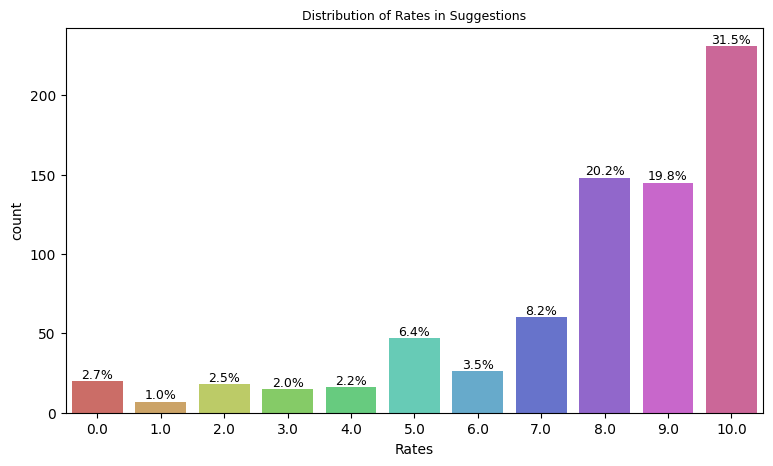

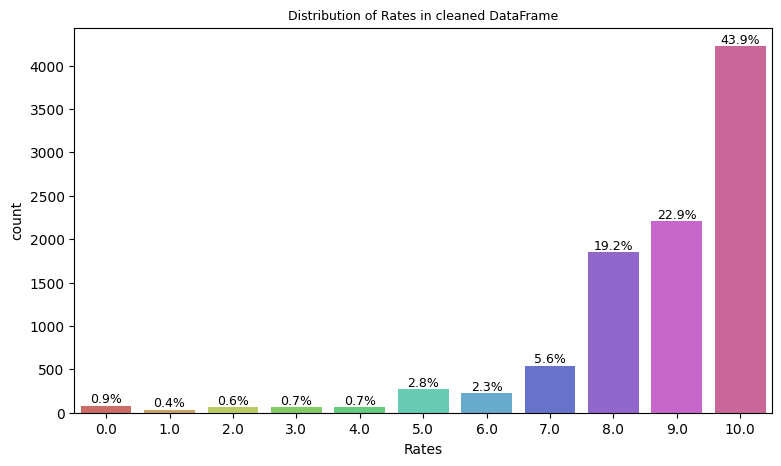

In [28]:
distribution(df_feedback,'Rates','Feedbacks') 
distribution(df_suggestion,'Rates','Suggestions')
distribution(df_clean,'Rates','cleaned DataFrame') 

#### Balancing and mapping our target

In [29]:
mapping = {0.0: 0, 1.0: 0, 2.0: 0, 3.0: 0, 4.0: 0, 5.0: 0, 6.0: 0, 7.0: 0,                 
           8.0: 1, 9.0: 1, 
           10.0: 2}

#### Defining our DataFrames

In [30]:
df_balanced_feedback = df_feedback.dropna(subset=['Rates']).copy()
df_balanced_suggestion = df_suggestion.dropna(subset=['Rates']).copy()
df_balanced_clean = df_clean.dropna(subset=['Rates']).copy()

df_balanced_feedback['Rates'] = df_balanced_feedback['Rates'].map(mapping)
df_balanced_suggestion['Rates'] = df_balanced_suggestion['Rates'].map(mapping)
df_balanced_clean['Rates'] = df_balanced_clean['Rates'].map(mapping)

#### Plotting our new balanced DataFrames

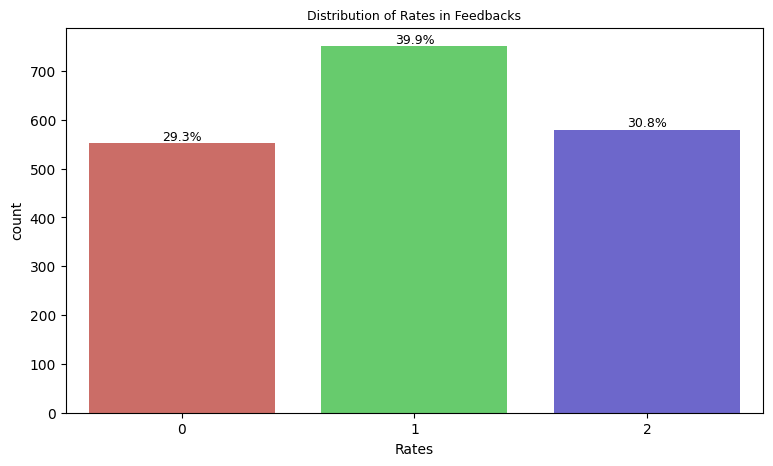

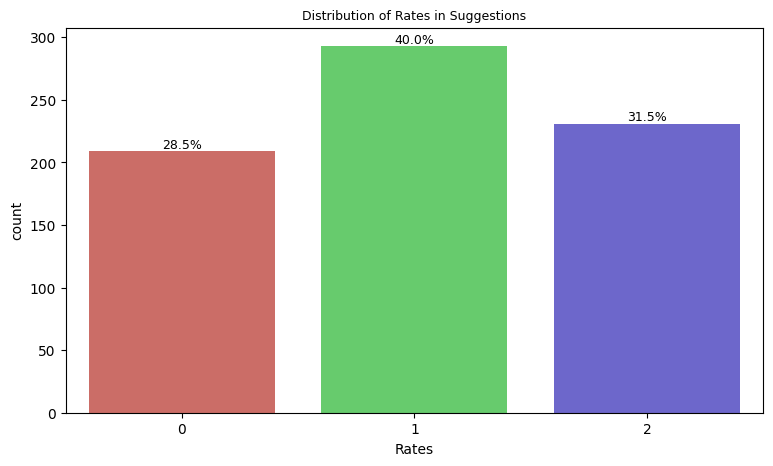

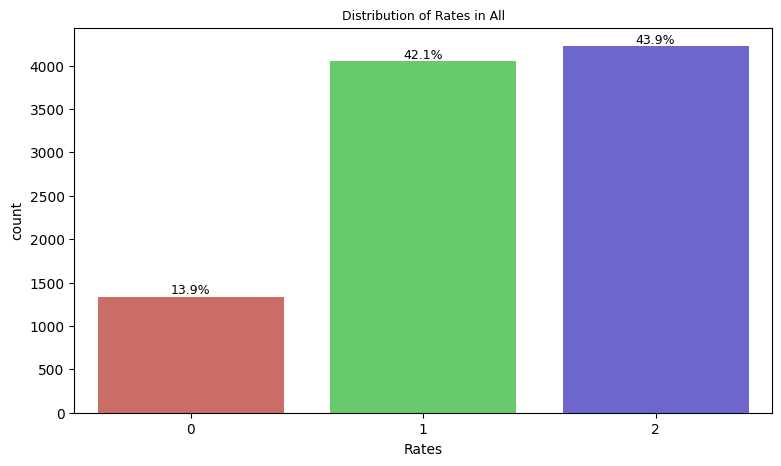

In [31]:
distribution(df_balanced_feedback,'Rates','Feedbacks') 
distribution(df_balanced_suggestion,'Rates','Suggestions')
distribution(df_balanced_clean,'Rates','All')

## Prediction of rates

#### Required libraries

In [32]:
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import classification_report

#### Required functions

In [33]:
def metrics_multiclass(xgb,x,y):
    y_pred = xgb.predict(x)
    y_prob = xgb.predict_proba(x)

    acc = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_prob, multi_class='ovr', average='macro')

    return (acc, auc)

def prediction(xgb, df, target, column, sampler=None):
    TF_IDF = TfidfVectorizer()

    Y = df[target]
    X = df[column]
    #X = TF_IDF.fit_transform(df[column])
    #X = pd.DataFrame(X.toarray())

    Y = df[target]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42,stratify=Y)

    x_train = TF_IDF.fit_transform(x_train)
    x_test = TF_IDF.transform(x_test)

    svd = TruncatedSVD(n_components = 1000, random_state = 42)
    x_train = svd.fit_transform(x_train)
    x_test = svd.transform(x_test)

    if sampler is not None:
        x_train, y_train = sampler.fit_resample(x_train, y_train)
        xgb.fit(x_train, y_train)
    else:
        sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)
        xgb.fit(x_train, y_train, sample_weight=sample_weights)
    
    training_acc,training_auc = metrics_multiclass(xgb,x_train,y_train)
    test_acc,test_auc = metrics_multiclass(xgb,x_test,y_test)

    print(f"\nSampler : {sampler}\nTRAIN | Accuracy : {training_acc:.2f}, AUC : {training_auc:.2f}\nTEST  | Accuracy : {test_acc:.2f}, AUC : {test_auc:.2f}")
    

#### Defining our model and samplers

In [34]:

sampler = [RandomUnderSampler(),RandomOverSampler()]
'''
xgb = XGBClassifier(n_estimators=1000,learning_rate=0.01,max_depth=3,random_state=24,
                    objective='multi:softprob',
                    num_class=3,
                    eval_metric='mlogloss')
'''

xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=3,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=0.1, # L2 regularization
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    random_state=24
)

#### Printing our results based on feedbacks

In [35]:
prediction(xgb, df_balanced_clean, 'Rates', 'Feedbacks_lem')
prediction(xgb, df_balanced_clean, 'Rates', 'Feedbacks_lem',sampler[0])
prediction(xgb, df_balanced_clean, 'Rates', 'Feedbacks_lem',sampler[1])


Sampler : None
TRAIN | Accuracy : 0.55, AUC : 0.67
TEST  | Accuracy : 0.46, AUC : 0.57

Sampler : RandomUnderSampler()
TRAIN | Accuracy : 0.54, AUC : 0.71
TEST  | Accuracy : 0.45, AUC : 0.57

Sampler : RandomOverSampler()
TRAIN | Accuracy : 0.52, AUC : 0.69
TEST  | Accuracy : 0.46, AUC : 0.56


## Topic modeling based on feedbacks

### Required libraries

In [54]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, Phrases
from gensim.models.phrases import Phraser
import spacy
import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.gensim_models as gensimvis

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.set_option('display.max_colwidth', None)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Disables parallel processing

In [55]:
df_topic = roberta_feedback.copy()
df_topic.head()

,roberta_neg,roberta_neu,roberta_pos,Rates,Satisfaction,Feedbacks_clean,Feedbacks_lem,Feedbacks_tokens
0,0.163168,0.786150,0.050682,5.0,0.0,sort out the airport own parking so it works when you prepay,sort parking work prepay,"[sort, parking, work, prepay]"
1,0.008323,0.143227,0.848450,10.0,1.0,was a first time thru edinburgh airport and was excellent all around service,first time thru excellent around service,"[first, time, thru, excellent, around, service]"
2,0.005589,0.209659,0.784752,5.0,1.0,the british airways check in staff were very kind and helpful,british airway check staff kind helpful,"[british, airway, check, staff, kind, helpful]"
3,0.046155,0.432210,0.521635,9.0,1.0,there should more easy accesible internet,easy accesible internet,"[easy, accesible, internet]"
4,0.051070,0.904834,0.044096,10.0,1.0,gate advisory not less than an hour from departure,gate advisory less hour departure,"[gate, advisory, less, hour, departure]"


### Negative Feedbacks

#### Required Functions

In [56]:
def make_ngram(texts):
    ngrams_docs = []
    for doc in trigram[bigram[texts]]:
        filtered_ngrams = [token for token in doc if "_" in token]
        ngrams_docs.append(filtered_ngrams)
    return ngrams_docs

#### Feedbacks with negativity over > 0.7

In [57]:
df_neg_bigram = roberta_feedback.loc[roberta_feedback['roberta_neg'] >= 0.7]

#### Adding bigrams and trigrams

In [58]:
df_neg_bigram = roberta_feedback.loc[roberta_feedback['roberta_neg'] >= 0.7]
dico_bigram = df_neg_bigram["Feedbacks_tokens"].tolist()

bigrams = Phrases(dico_bigram, min_count = 5, threshold = 10)
trigrams = Phrases(bigrams[dico_bigram], threshold = 10)

bigram = Phraser(bigrams)
trigram = Phraser(trigrams)

df_neg_bigram.loc[:, 'ngram'] = make_ngram(dico_bigram)

/var/folders/nm/0ybs5yz92sz5t70hz12_q19c0000gn/T/ipykernel_85100/498941186.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg_bigram.loc[:, 'ngram'] = make_ngram(dico_bigram)


#### Clustering

In [59]:
col = 'ngram'
id2word_neg_bigram = corpora.Dictionary(df_neg_bigram[col])
#df_neg_bigram['id2word'] = df_neg_bigram[col].apply(lambda x: id2word_neg_bigram.doc2bow(x))
df_neg_bigram.loc[:, 'id2word'] = df_neg_bigram[col].apply(lambda x: id2word_neg_bigram.doc2bow(x))
corpus_neg_bigram = list(df_neg_bigram['id2word'])

k = 4

lda_model_neg = gensim.models.ldamodel.LdaModel(
    corpus = corpus_neg_bigram,              
    id2word = id2word_neg_bigram,           
    num_topics = k,              
    random_state = 100,           
    update_every = 1,             
    chunksize = len(corpus_neg_bigram),      
    passes=20,                  
    alpha="auto",               
    per_word_topics=True,       
    iterations=100 )

vis = gensimvis.prepare(lda_model_neg, corpus_neg_bigram, id2word_neg_bigram, mds = "mmds", R=5,sort_topics=True)
pyLDAvis.display(vis)

/var/folders/nm/0ybs5yz92sz5t70hz12_q19c0000gn/T/ipykernel_85100/3254124534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg_bigram.loc[:, 'id2word'] = df_neg_bigram[col].apply(lambda x: id2word_neg_bigram.doc2bow(x))


In [60]:
def get_dominant_topic_neg_bigram(text):
    bow = id2word_neg_bigram.doc2bow(text)
    #print(bow)
    topics = lda_model_neg[bow]
    topics = topics[0]
    #print(topics)
    l = len(topics)
    #print (l)
    max = 0
    top = 0
    for i in range (l):
        #print (topics[i][1])
        if topics[i][1] > max:
            max = topics[i][1]
            top = topics[i][0]
    if top == 0:
        return (2)
    elif top == 1:
        return (4)
    elif top == 2:
        return (1)
    elif top == 3:
        return (3)

#get_dominant_topic_neg_bigram(['luggage_trolley'])
#0 c'est le topic 2
#1 c'est le topic 4
#2 c'est le topic 1
#3 c'est le topic 3

In [61]:
df_neg_bigram.loc[:,'dominant_topic'] = df_neg_bigram['ngram'].apply(get_dominant_topic_neg_bigram)
df_neg_bigram_clean = df_neg_bigram[df_neg_bigram['ngram'].apply(lambda x: len(x) > 0)]

/var/folders/nm/0ybs5yz92sz5t70hz12_q19c0000gn/T/ipykernel_85100/271555688.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg_bigram.loc[:,'dominant_topic'] = df_neg_bigram['ngram'].apply(get_dominant_topic_neg_bigram)


#### Topic 1 : Car Park, Car Parking

In [62]:
k = 1
topic_1 = df_neg_bigram_clean.loc[df_neg_bigram_clean['dominant_topic'] == k]
topic_1[['roberta_neg','Feedbacks_clean','dominant_topic']].sort_values(by='roberta_neg', ascending=False).head(5)

,roberta_neg,Feedbacks_clean,dominant_topic
1205,0.930578,the airport is looking tired and scruffy \npaying to use luggage carts on arrival back in to edinburgh crazy \ncar parking fees for drop off pure extortion,1
1457,0.882027,edinburgh airport is better than glasgow airport without a doubt however my god first thing you see once you step foot in this country is the utter disgraceful passport check built in a refurbished warehouse its an embarrassment go to other countries and see their grand airports and take notes the queue was ridiculous as the small warehouse where we are packed like cattle waiting for our turn to get checked or scanned in is abysmal and i am ashamed that visitors of our country need to go through that the start of my holiday hype was shattered as i had booked airport parking for my car in the long stay however the sheer lack of spaces and orangisation is shocking i think i was very lucky to find a space cars parked up curbs and up platforms to just get a space and car parked in the connecting roads of the car parking is shocking all these people like myself pay money to get a space and it appears they are not guaranteed a space shocking and embarrassing,1
162,0.856294,car parking is ludicrously and indefensibly expensive car park ticket machines do not take payments from phones slowing everyone else down the exit experience for domestic passengers is depressingly lowrent stumbling down a cheap set of stairs and the current private hire contract with capital cars is an utter disaster for passengers more expensive for every single journey and their drivers are a danger to everyone,1
984,0.820326,try focus on how to serving people better rather than exploiting people to pay extra unnecessary services the car park is rubbish and took a long way to walk you cannot even drop people off without paying,1
258,0.802918,having travelled back to edinburgh on numerous occasions i think that the short stay car parking is exceptionally expensive in comparison to australia i lived in edinburgh for many years before emigrating to australia and i cannot get over the fact that there are thousands of pieces of discarded chewing gum littering every walkway it makes the airport look scruffy and unkempt i firmly believe that as an international airport you should be considering first impressions and not friendliness of staff which i know is a given,1


Couts extrêmement élevés : Les passagers décrivent les frais de stationnement comme "absurdes", surtout pour les zones de depose minutes, les qualifiant de "pure extorsion".

Places limitées : Le parking longue durée manque de places, obligeant les conducteurs à se garer sur les trottoirs ou à marcher longtemps. Aucune place garantie malgré une réservation préalable.

Systèmes de paiement obsolètes : Les distributeurs de tickets n'acceptent pas les paiements mobiles, causant des retards et de la frustration.

Mauvaise organisation et accessibilité : Une disposition confuse, de longues marches jusqu'aux terminaux et aucune option de dépôt gratuit.

#### Topic 2 : Passeport control / Queues

In [43]:
k = 2
topic_2 = df_neg_bigram_clean.loc[df_neg_bigram_clean['dominant_topic'] == k]
topic_2[['roberta_neg','Feedbacks_clean','dominant_topic']].sort_values(by='roberta_neg', ascending=False).head(5)

,roberta_neg,Feedbacks_clean,dominant_topic
772,0.960079,arrival process is an absolute embarrassment too many stairsdirty corridors and massive queues at passport control been the same for years and is getting worse,2
172,0.954075,arriving at edinburgh is a disgrace for an international airport made to walk poor weather does not help stairs cramped walkways poor passport control set up horrendously dirty toilets time to wait on luggage absolutely embarrassing welcome to scotland\ni travel to multiple airports countries per year and edinburgh is seriously down there with the worst get your finger out,2
1903,0.940460,long queues at security are annoying and time consuming,2
171,0.922397,very disappointed with a number of issues firstly i enquired about ordering duty free to be collected on my return and was told that you did not do that yet you have adverts all over the place promoting just that secondly there is always a delay waiting for baggage on my return carousel broke down they had to man handle the skis and some of the bags eventually\nevery year when i go through passport control i stand in a huge queue for the automatic check which never works for me eventually the automatic rejects me and i have go through a manual check why could i not go through manual to start with \nit was the same when i travelled for business for many years i am nearly and standing for that ridiculous length of time is extremely hard going,2
1657,0.918219,yes when returning to edinburgh rather than force everyone through electronic passport control when the hall is over flowing and there are border control officers sitting doing nothing allow passengers to use that side also absolutely ridiculous and totally unprofessional,2


- Files d'attente longues et chaotiques :
Les temps d'attente excessifs aux contrôles de passeport sont qualifiés de "honte absolue". Les portiques électroniques tombent souvent en panne, obligeant les passagers à passer par des contrôles manuels après des retards inutiles.

- Aménagement mal conçu :
L'arrivée implique des escaliers, des couloirs étroits et des passages sales - une situation aggravée par les intempéries. Le personnel des frontières reste parfois inactif alors que les files d'attente débordent.

- Processus inefficaces :
Aucune flexibilité pour contourner les portiques électroniques défectueux ; les contrôles manuels devraient être disponibles immédiatement. Les voyageurs d'affaires et les personnes âgées peinent à rester debout si longtemps.

- Première impression désastreuse :
Des toilettes sales, des retards de bagages et une organisation désordonnée créent un accueil "scandaleux" pour les visiteurs arrivant en Écosse.

#### Topic 3 : Duty Free

In [44]:
k = 3
topic_3 = df_neg_bigram_clean.loc[df_neg_bigram_clean['dominant_topic'] == k]
topic_3[['roberta_neg','Feedbacks_clean','dominant_topic']].sort_values(by='roberta_neg', ascending=False).head(5)

,roberta_neg,Feedbacks_clean,dominant_topic
1720,0.921821,duty free worker was a rude cow,3
1763,0.894892,forcing passengers to walk through the misery that is duty free is a disgrace way way too much commercial messaging around the airport its a travel hub not a shopping centre hate the way the airport operates,3
1397,0.887951,i find the amount of construction work annoying as it forces people to clog up certain areas of the terminal after duty free,3
1215,0.882387,lack of seating before security \n\nno consideration for passengers with breathing difficulties by forcing them through perfume section at duty free\n\nthe wooden seats with slats are extremely uncomfortable for thin people,3
1813,0.830185,hate having to meander through duty free en route to main terminal this makes me less likely to buy indeed it creates a negative buying mentality due to the forced nature of the retail experience,3


- Comportement du staff : Une employée de la zone duty-free a été décrite comme impolie et peu professionnelle.

- Parcours imposé : Les passagers déplorent d'être obligés de traverser la zone duty-free, qualifiant cette expérience de "misérable" et de "honteuse".

- Surcharge commerciale : La quantité excessive de publicités et de boutiques donne l'impression d'un centre commercial plutôt que d'un aéroport.

- Problèmes de travaux : Les chantiers en cours créent des embouteillages, particulièrement après la zone duty-free.

#### Topic 4 : Luggage Trolley

In [63]:
k = 4
topic_4 = df_neg_bigram_clean.loc[df_neg_bigram_clean['dominant_topic'] == k]
topic_4[['roberta_neg','Feedbacks_clean','dominant_topic']].sort_values(by='roberta_neg', ascending=False).head(5)

,roberta_neg,Feedbacks_clean,dominant_topic
625,0.966749,the idea of having to pay at an international airport for a luggage trolley is pathetic and embarrassing it greatly inconveniences passengers and is the worst idea i have seen at an airport in some time,4
831,0.961746,the luggage trolley charging system is an absolute disgrace the infrastructure airside is shocking edinburgh airport is an embarrassment as scotlands capital airport the greedy owners should be ashamed of themselves,4
1030,0.923676,it is disheartening and frustrating to see charges for services which should be free eg drop off near airport use of luggage trolley for use of a luggage trolley is outrageous,4
1524,0.891941,stop the charge for luggage trolleys it gives a very bad image of scotland to new visitors,4
198,0.854326,you need to stop monetising everything cost of drop off is ridiculous and i noticed you now need to pay for a luggage trolley,4


- Frais injustes : Les passagers s'opposent fermement au paiement des chariots à bagages, qualifiant cette pratique de "pathétique", "humiliante" et "scandaleuse".

- Image négative : Ces frais nuisent à la réputation de l’Écosse auprès des visiteurs et ternissent l’image de l’aéroport d’Édimbourg en tant que hub d’une capitale.

- Inconvénients majeurs : Le système payant complique inutilement le voyage, surtout lorsqu’il s’ajoute à d’autres frais comme ceux pour le depose minute

- Critiques des gerants : Les passagers accusent les gestionnaires de l’aéroport d’être "avides" en monétisant des services qui devraient être gratuits.